In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Camera Calibration and Distrotion Coefficients

In [2]:
def calibrate_camera(images, nx, ny):
    
    # Array to store object points and image points from all the images
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in images plane

    # Prepare object points, like (0,0,0), (1,0,0),...
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

    for fname in images:
        # Read in each image
        img = cv2.imread(fname)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If corners are found, draw corners
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

    # Camera calibration, given object points, image points, and the shape of the grayscale image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return ret, mtx, dist, rvecs, tvecs

## Apply a distortion correction to raw images

In [4]:
def distortion_correction(image, mtx, dist):
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    return dst

# # Make a list of calibration images
# images = glob.glob('./calibration_wide/*.jpg')

# # Prepare object points
# nx = 8
# ny = 6

# ret, mtx, dist, rvecs, tvecs = calibrate_camera(images, nx, ny)

# test_img = mpimg.imread('./test_images/test1.jpg')
# dist_img = distortion_correction(test_img, mtx, dist)

# plt.axis('off')
# plt.imshow(dist_img);

## Gradient Transform

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, gaussian_kernel=5, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Gaussian Filter
    blur_gray = cv2.GaussianBlur(gray, (gaussian_kernel, gaussian_kernel), 0)
    # Apply x or y gradient and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(blur_gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(blur_gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary

def mag_threshold(img, sobel_kernel=3,  gaussian_kernel=5,mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Gaussian Gilter
    blur_gray = cv2.GaussianBlur(gray, ( gaussian_kernel,  gaussian_kernel), 0)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(blur_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(blur_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return mag_binary

def dir_threshold(img, sobel_kernel=3, gaussian_kernel=5, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Gaussian Filter
    blur_gray = cv2.GaussianBlur(gray, (gaussian_kernel, gaussian_kernel), 0)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(blur_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(blur_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return dir_binary

def gradient_transform(img, sobel_kernel=3, gaussian_kernel=5, grad_thresh=(0, 255), mag_thresh=(0, 255), dir_thresh=(0, np.pi/2)):
    
    # Create x and y gradients images
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, gaussian_kernel=gaussian_kernel, thresh=grad_thresh)
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, gaussian_kernel=gaussian_kernel, thresh=grad_thresh)
    
    # Create magnitude image
    mag_binary = mag_threshold(img, sobel_kernel=ksize, gaussian_kernel=gaussian_kernel, mag_thresh=mag_thresh)
    
    # Create gradient direction image
    dir_binary = dir_threshold(img, sobel_kernel=ksize, gaussian_kernel=gaussian_kernel, thresh=dir_thresh)
    
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined_binary

# # Choose a Sobel kernel size
# ksize = 9 # Choose a larger odd number to smooth gradient measurements

# # Choose gaussian filter size
# gaussian_kernel = 5

# # combined = gradient_transform(dist_img, ksize, gaussian_kernel, grad_thresh=(20, 100), mag_thresh=(30, 100), dir_thresh=(0.7, 1.3))

# # Apply each of the thresholding functions
# gradx = abs_sobel_thresh(dist_img, orient='x', sobel_kernel=ksize, gaussian_kernel=gaussian_kernel, thresh=(20, 100))
# grady = abs_sobel_thresh(dist_img, orient='y', sobel_kernel=ksize, gaussian_kernel=gaussian_kernel, thresh=(20, 100))
# mag_binary = mag_threshold(dist_img, sobel_kernel=ksize, gaussian_kernel=gaussian_kernel, mag_thresh=(30, 100))
# dir_binary = dir_threshold(dist_img, sobel_kernel=ksize, gaussian_kernel=gaussian_kernel, thresh=(0.7, 1.3))

# combined = np.zeros_like(dir_binary)
# combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# combined_and = np.zeros_like(dir_binary)
# combined_and[((gradx == 1) & (grady == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1

# # Display output images
# f, ax = plt.subplots(3,2, figsize=(20, 20))

# ax[0, 0].imshow(gradx, cmap='gray')
# ax[0, 1].imshow(grady, cmap='gray')
# ax[1, 0].imshow(mag_binary, cmap='gray')
# ax[1, 1].imshow(dir_binary, cmap='gray')
# ax[2, 0].imshow(combined, cmap='gray')
# ax[2, 1].imshow(combined_and, cmap='gray')

# ax[0, 0].set_title("Grad x")
# ax[0, 1].set_title("Grad y")
# ax[1, 0].set_title("Magnitude")
# ax[1, 1].set_title("Direction")
# ax[2, 0].set_title("Combined")
# ax[2, 1].set_title("Combined AND")

# ax[0, 0].axis('off')
# ax[0, 1].axis('off')
# ax[1, 0].axis('off')
# ax[1, 1].axis('off')
# ax[2, 0].axis('off')
# ax[2, 1].axis('off')

# f.subplots_adjust(wspace=0.01, hspace=0)

## Color Transform

In [7]:
def gray_binary(img, gaussian_kernel=5, thresh=(180, 255)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply Gaussian Filter
    blur_gray = cv2.GaussianBlur(gray, (gaussian_kernel, gaussian_kernel), 0)
    # Apply threshold
    gray_binary = np.zeros_like(blur_gray)
    gray_binary[(blur_gray > thresh[0]) & (blur_gray <= thresh[1])] = 1
    
    return gray_binary

def red_binary(img, gaussian_kernel=5, thresh=(200, 255)):
    
    # Retrieve red channel
    red = img[:,:,0]
    # Apply Gaussian Filter
    blur_red = cv2.GaussianBlur(red, (gaussian_kernel, gaussian_kernel), 0)
    
    # Apply threshold
    red_binary = np.zeros_like(blur_red)
    red_binary[(blur_red > thresh[0]) & (blur_red <= thresh[1])] = 1
    
    return red_binary

def h_binary(img, gaussian_kernel=5, thresh=(15, 100)):
    
    # Get hls channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Apply Gaussian Filter
    blur_hls = cv2.GaussianBlur(hls, (gaussian_kernel, gaussian_kernel), 0)
    
    # Retrieve h channel
    h = blur_hls[:,:,0]
    
    # Apply threshold
    h_binary = np.zeros_like(h)
    h_binary[(h > thresh[0]) & (h <= thresh[1])] = 1
    
    return h_binary

def s_binary(img, gaussian_kernel=5, thresh=(90, 255)):
    
    # Get hls channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Apply Gaussian Filter
    blur_hls = cv2.GaussianBlur(hls, (gaussian_kernel, gaussian_kernel), 0)
    
    # Retrieve h channel
    s = blur_hls[:,:,2]
    
    # Apply threshold
    s_binary = np.zeros_like(s)
    s_binary[(s > thresh[0]) & (s <= thresh[1])] = 1
    
    return s_binary

def color_transform(img, gaussian_kernel=5, gray_thresh=(180, 255), red_thresh=(200, 255), h_thresh=(15, 100), s_thresh=(90, 255)):
    
    # Create gray image
    gray_img = gray_binary(img, thresh=gray_thresh)
    blur_gray = cv2.GaussianBlur(gray_img, (gaussian_kernel, gaussian_kernel), 0)
    # Create red image
    red_img = red_binary(img, thresh=red_thresh)
    
    # Create h channel image
    h_img = h_binary(img, gaussian_kernel=gaussian_kernel, thresh=h_thresh)
    
    # Create s channel image
    s_img = s_binary(img, gaussian_kernel=gaussian_kernel, thresh=s_thresh)
    
    combined_binary = np.zeros_like(s_img)
    combined_binary[((gray_img == 1) & (red_img == 1)) | ((h_img == 1) & (s_img == 1))] = 1
#     [((blur_gray == 1) | (red_img == 1)) | ((h_img == 1) | (s_img == 1))] = 1
    
    return combined_binary

# # Choose gaussian filter size
# gaussian_kernel = 5

# # Apply each of the thresholding functions
# gray_img = gray_binary(dist_img, gaussian_kernel, (180, 255))
# red_img = red_binary(dist_img, gaussian_kernel, (200, 255))
# h_img = h_binary(dist_img, gaussian_kernel, (15, 100))
# s_img = s_binary(dist_img, gaussian_kernel, (90, 255))

# combined_color = color_transform(dist_img, gaussian_kernel, gray_thresh=(180, 255), red_thresh=(200, 255), h_thresh=(15, 100), s_thresh=(90, 255))

# combined_color2 = np.zeros_like(s_img)
# combined_color2[((gray_img == 1) & (red_img == 1)) | ((h_img == 1) & (s_img == 1))] = 1

# # Display output images
# f, ax = plt.subplots(3,2, figsize=(20, 20))

# ax[0, 0].imshow(gray_img, cmap='gray')
# ax[0, 1].imshow(red_img, cmap='gray')
# ax[1, 0].imshow(h_img, cmap='gray')
# ax[1, 1].imshow(s_img, cmap='gray')
# ax[2, 0].imshow(combined_color, cmap='gray')
# ax[2, 1].imshow(combined_color2, cmap='gray')

# ax[0, 0].set_title("Grayscale")
# ax[0, 1].set_title("Red channel")
# ax[1, 0].set_title("H channel")
# ax[1, 1].set_title("S channel")
# ax[2, 0].set_title("Combined")
# ax[2, 1].set_title("Combined 2")

# ax[0, 0].axis('off')
# ax[0, 1].axis('off')
# ax[1, 0].axis('off')
# ax[1, 1].axis('off')
# ax[2, 0].axis('off')
# ax[2, 1].axis('off')

# f.subplots_adjust(wspace=0.01, hspace=0)

## Color transforms and gradients to create a thresholded binary image

In [8]:
def color_gradient_transform(img, sobel_size=9, gaussian_kernel=5,
                             grad_thresh=(20, 100), mag_thresh=(30, 100), dir_thresh=(0.7, 1.3),
                             gray_thresh=(180, 255), red_thresh=(200, 255), h_thresh=(15, 100), s_thresh=(90, 255)):
    img = np.copy(img)
    
    # Gradient transform
    gradient_binary = gradient_transform(img, sobel_size, gaussian_kernel,
                                         grad_thresh=grad_thresh, mag_thresh=mag_thresh, dir_thresh=dir_thresh)
    
    # Color transform
    color_binary = color_transform(img, gaussian_kernel,
                                   gray_thresh=gray_thresh, red_thresh=red_thresh, h_thresh=h_thresh, s_thresh=s_thresh)
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(gradient_binary)
    combined_binary[(color_binary == 1) | (gradient_binary == 1)] = 1
    
    return combined_binary

# ksize = 9 # Choose a larger odd number to smooth gradient measurements
# gaussian_kernel = 5
# test_trasf = color_gradient_transform(dist_img, ksize, gaussian_kernel,
#                                       grad_thresh=(20, 100), mag_thresh=(30, 100), dir_thresh=(0.7, 1.3),
#                                       gray_thresh=(180, 255), red_thresh=(200, 255), h_thresh=(15, 100), s_thresh=(90, 255))

# plt.axis('off')
# plt.imshow(test_trasf, cmap='gray');

## Perspective transform to rectify binary image ("birds-eye view")

In [9]:
def perspective_trasform(image):
    
    img_size = (image.shape[1], image.shape[0])
    
    # Define source points and destination points
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 5), 0],
        [(img_size[0] / 5), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Calculate inverse perspective matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    
    # Return the resulting image
    return warped, Minv

# test_warped, Minv = perspective_trasform(masked_img)
# plt.axis('off')

# plt.imshow(test_warped, cmap='gray');

## Detect lane pixels and fit to find the lane boundary (test images)

In [10]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Split histogram into two sides (find the left and right peak)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 

        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) &
                          (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) &
                          (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`rightx_current` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to find the parameters A, B, C for the equation of a line
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate y values for plotting the fitted lines
    # (Just equally spaced points along the y axis)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    try:
        # Generate x values for plotting fitted lines
        # Used later to unwarp image back
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left_fit` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    # plt.plot(left_fitx, ploty, color='yellow')
    # plt.plot(right_fitx, ploty, color='yellow')
    
    # Get vehicle deviation
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit a second order polynomial with pixels to meters conversion
    # I want new coefficients "in meters" rather than pixels
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    
    # Define y-value where we want to calculate the deviation
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    bottom_y = np.max(ploty) * ym_per_pix
    
    # Use equation of the line to find both left and right lane position at bottom image
    bottom_left = left_fit_cr[0] * bottom_y ** 2 + left_fit_cr[1] * bottom_y + left_fit_cr[2]
    bottom_right = right_fit_cr[0] * bottom_y ** 2 + right_fit_cr[1] * bottom_y + right_fit_cr[2]
    
    lane_center = (bottom_left + bottom_right) / 2.0
    image_center = binary_warped.shape[1] / 2.0 * xm_per_pix
    
    deviation = image_center - lane_center

    return out_img, ploty, left_fit_cr, right_fit_cr, left_fitx, right_fitx, deviation

# out_img, ploty, left_fit_cr, right_fit_cr, left_fitx, right_fitx, deviation = fit_polynomial(test_warped)

# print('Deviation from center: ', deviation, ' m')

# plt.axis('off')
# plt.imshow(out_img);

## Determine the curvature of the lane and vehicle position with respect to center

In [11]:
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculate the radius of curvature in meters for both lane lines. Should see values of ~1000
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad
# left_curverad, right_curverad = measure_curvature_real(ploty, left_fit_cr, right_fit_cr)
# print(left_curverad)
# print(right_curverad)

## Warp the detected lane boundaries back onto the original image

In [12]:
def warp_lane_back(warped_image, original_img, ploty, left_fitx, right_fitx, Minv):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original_img.shape[1], original_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)
    
    return result

# warp_lane_img = warp_lane_back(test_warped, dist_img, ploty, left_fitx, right_fitx, Minv)

# plt.axis('off')
# plt.imshow(warp_lane_img);

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

In [13]:
def display_curv_pos(image, radius, deviation):
    font = cv2.FONT_HERSHEY_SIMPLEX
    rad = int(radius)
    img_text = cv2.putText(image,'Radius of Curvature = {} (m)'.format(rad),(100,100), font, 2, (255, 255, 255), 2, cv2.LINE_AA)
    if deviation > 0:
        offset = str(abs(round(deviation, 3))) + ' m right'
    elif deviation < 0:
        offset = str(abs(round(deviation, 3))) + ' m left'
    img_text = cv2.putText(img_text,'Vehicle is {} of center'.format(offset),(100,200), font, 2, (255, 255, 255), 2, cv2.LINE_AA)
    return img_text

# final_img = display_curv_pos(warp_lane_img, (left_curverad + right_curverad) / 2, deviation)
# # cv2.imwrite('./pipeline_images/final_img.jpg', cv2.cvtColor(final_img, cv2.COLOR_RGB2BGR))

# plt.axis('off')
# plt.imshow(final_img);

## Pipeline (test images)

In [20]:
def pipeline(image, mtx, dist, ksize, gaussian_kernel):
    dist_img = distortion_correction(image, mtx, dist)
    test_trasf = color_gradient_transform(dist_img, ksize, gaussian_kernel,
                                      grad_thresh=(20, 100), mag_thresh=(30, 100), dir_thresh=(0.7, 1.3),
                                      gray_thresh=(180, 255), red_thresh=(200, 255), h_thresh=(15, 100), s_thresh=(90, 255))    
    test_warped, Minv = perspective_trasform(test_trasf)
    out_img, ploty, left_fit_cr, right_fit_cr, left_fitx, right_fitx, deviation = fit_polynomial(test_warped)
    left_curverad, right_curverad = measure_curvature_real(ploty, left_fit_cr, right_fit_cr)
    warp_lane_img = warp_lane_back(test_warped, dist_img, ploty, left_fitx, right_fitx, Minv)
    final_img = display_curv_pos(warp_lane_img, (left_curverad + right_curverad) / 2, deviation)
    return final_img

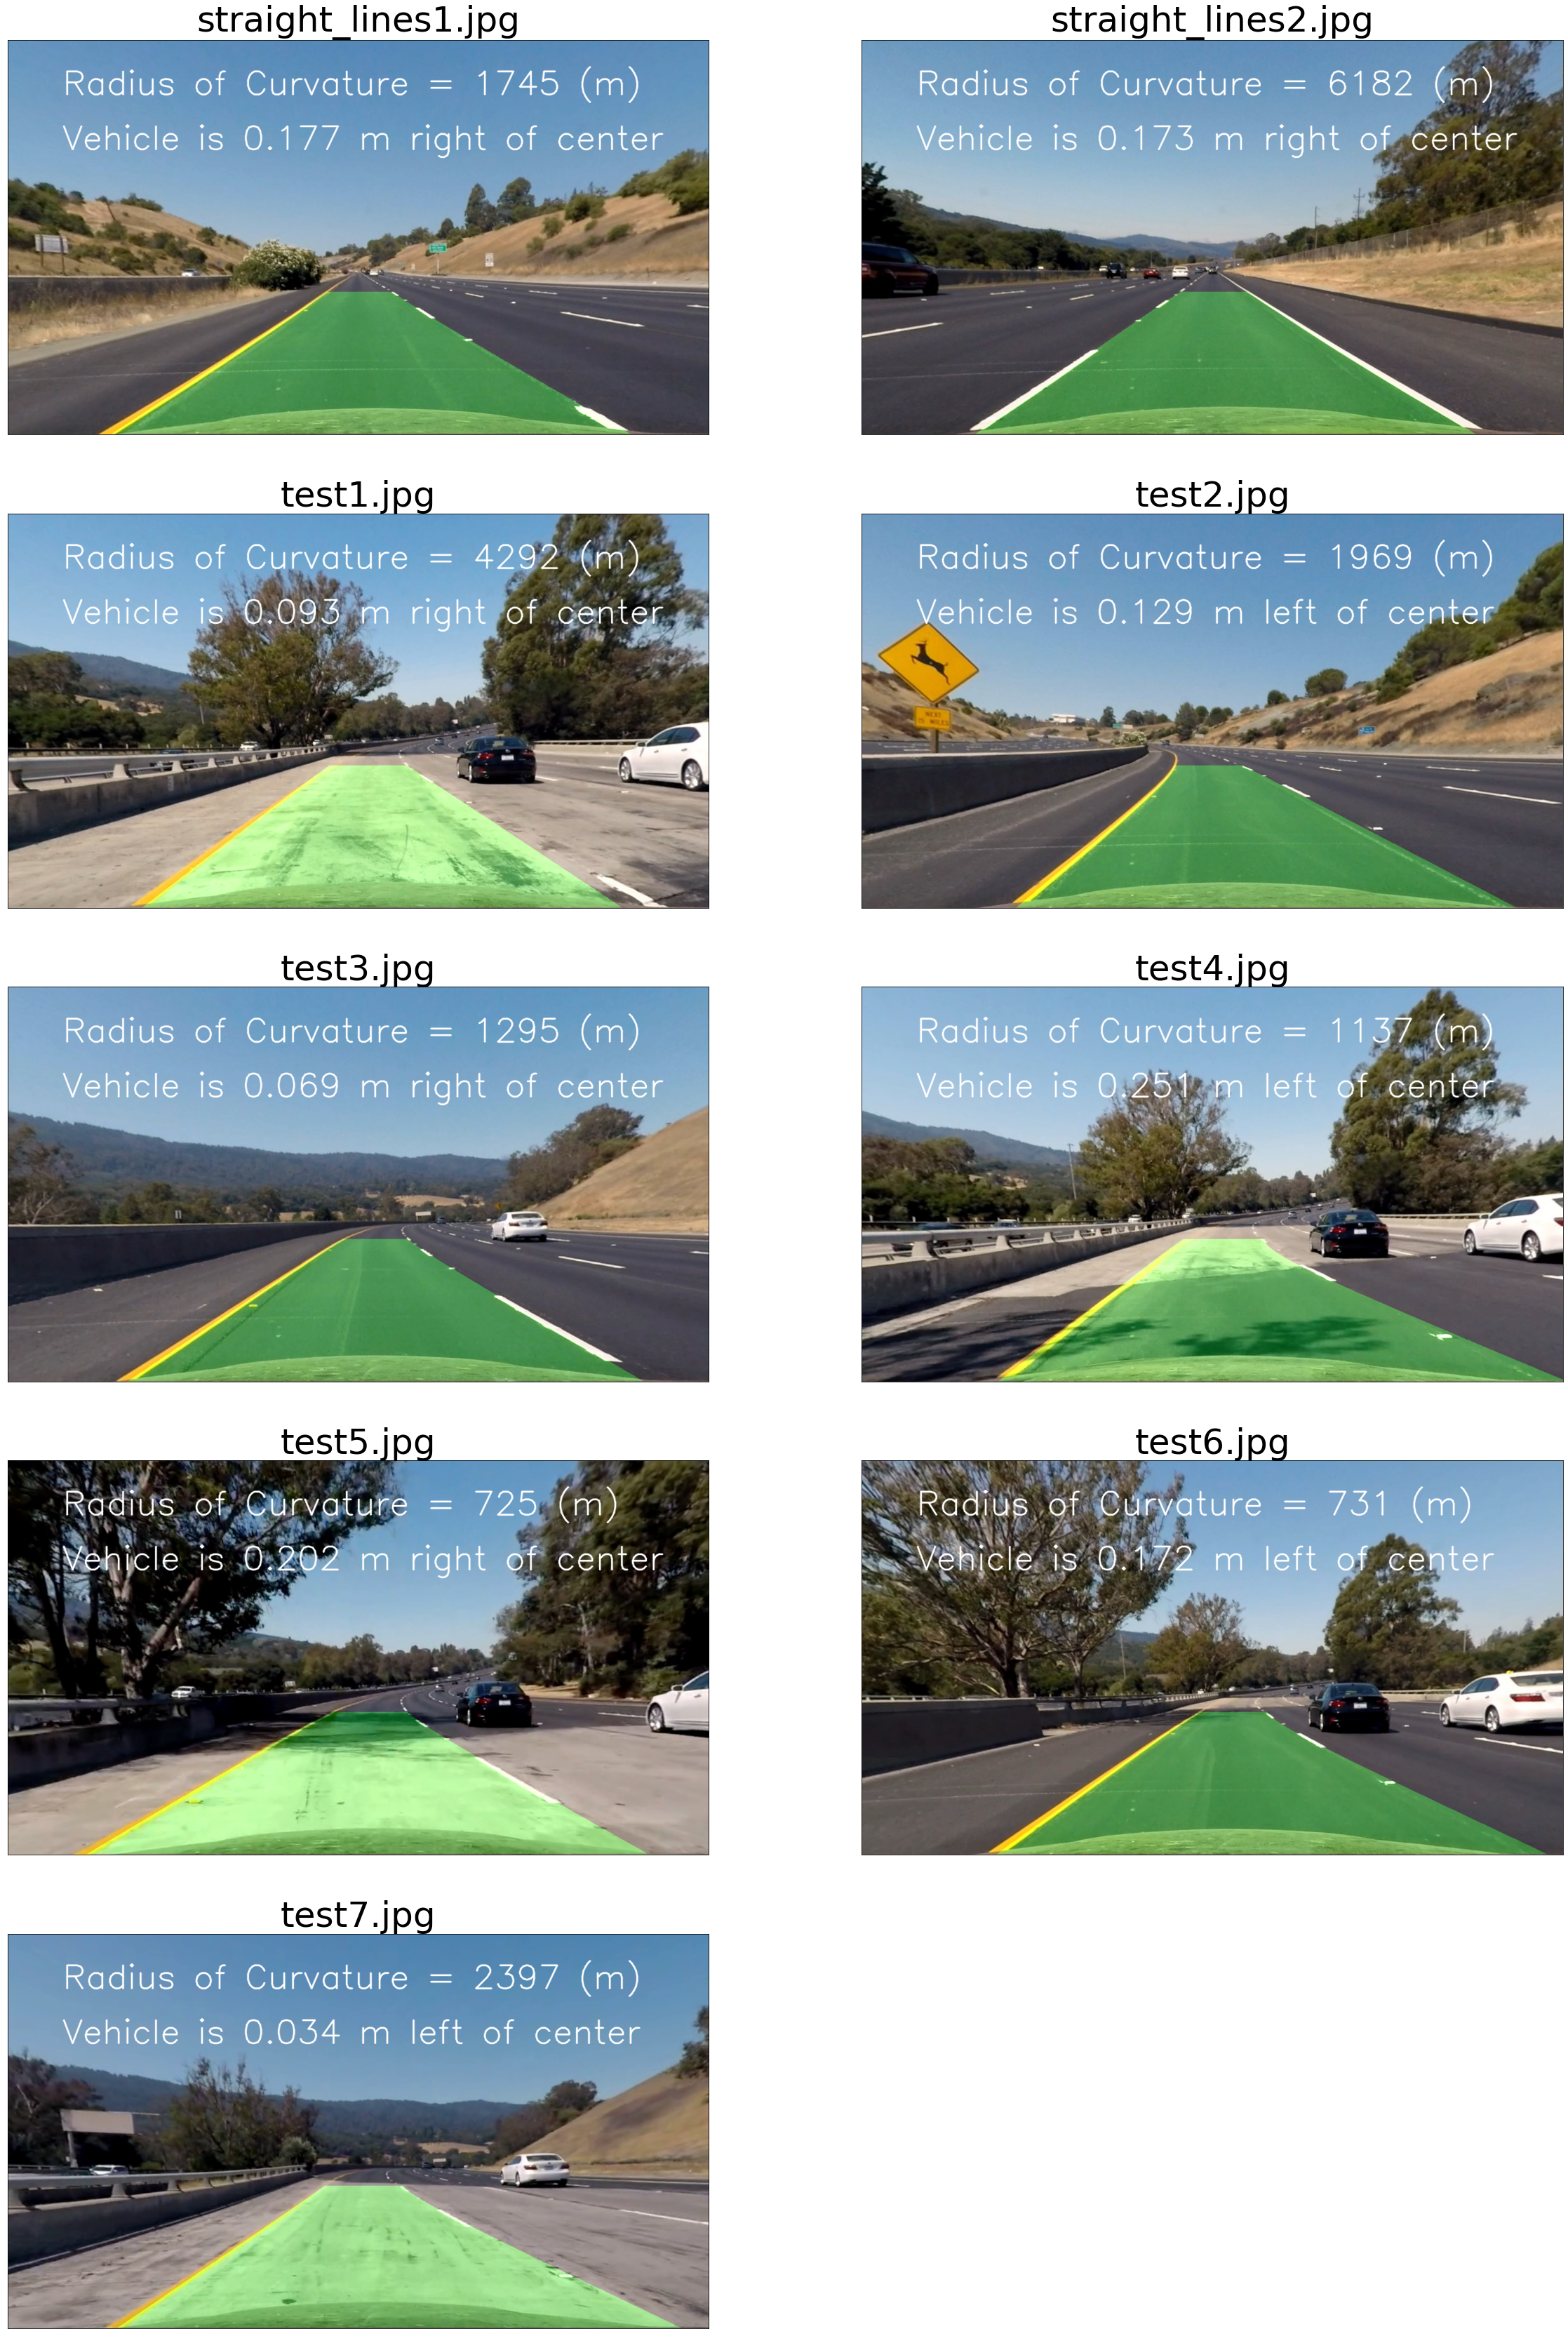

In [34]:
# Make a list of calibration images
images = glob.glob('./calibration_wide/*.jpg')

# Prepare object points
nx = 8
ny = 6

ret, mtx, dist, rvecs, tvecs = calibrate_camera(images, nx, ny)

filenames = glob.glob('./test_images/*.jpg')

# Choose filter size
ksize = 9

# Choose gaussian kernel size
gaussian_kernel = 5

# Display output images
fig = plt.figure(figsize=(40, 60))
    
for i, img_name in enumerate(filenames):
    ax = fig.add_subplot(5, 2, i+1)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    img = mpimg.imread(img_name)
    final_img = pipeline(img, mtx, dist, ksize, gaussian_kernel)
    cv2.imwrite('./output_images/{}'.format(img_name.split('\\')[1]), cv2.cvtColor(final_img, cv2.COLOR_RGB2BGR))
    plt.title(img_name.split('\\')[1], fontsize=50)
    plt.imshow(final_img)

## Detect lane pixels and fit to find the lane boundary (video)

In [14]:
class Line():
    """
    An Helper Class to keep track of the detected Lanes
    """
    
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

def find_lane_pixels(binary_warped):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Split histogram into two sides (find the left and right peak)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) &
                          (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) &
                          (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`rightx_current` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
            
    return leftx, lefty, rightx, righty, out_img

# Polynomial fit values from the previous frame
def search_around_poly(binary_warped, left_lane, right_lane):
    
    # HYPERPARAMETER
    margin = 100
    
    # Retrieve lanes previous fit
    prev_left_fit, prev_right_fit = left_lane.best_fit, right_lane.best_fit

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + 
                    prev_left_fit[2] - margin)) & (nonzerox < (prev_left_fit[0]*(nonzeroy**2) + 
                    prev_left_fit[1]*nonzeroy + prev_left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + 
                    prev_right_fit[2] - margin)) & (nonzerox < (prev_right_fit[0]*(nonzeroy**2) + 
                    prev_right_fit[1]*nonzeroy + prev_right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

def check_line_correct(line, fity, fitx):
    """
    Finds the best fit for the current lane
    """
    
    radius = line.radius_of_curvature
        
    if radius < 3000 and radius > 200:
        line.detected = True
        line.best_fit = line.current_fit.copy()
        line.allx = fitx
        line.ally = fity
    else:
        line.detected = False
        
    return line.best_fit, line.allx, line.ally
    

def fit_polynomial(binary_warped, left_line, right_line):
    
    left_line = left_line
    right_line = right_line
    
    if left_line.detected and right_line.detected:
        leftx, lefty, rightx, righty = search_around_poly(binary_warped, left_line, right_line)
        
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    else:
        # Find lanes in current frame
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # Fit a second order polynomial to find the parameters A, B, C for the equation of a line
    # Add current fit to lane
    left_line.current_fit = np.polyfit(lefty, leftx, 2)
    right_line.current_fit = np.polyfit(righty, rightx, 2)

    # Generate y values for plotting the fitted lines
    # (Just equally spaced points along the y axis)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit a second order polynomial to pixel positions in each lane line (this is in meters)
    # I want new coefficients "in meters" rather than pixels
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    
    # Calculate the radius of curvature for the check on the lanes
    left_line.radius_of_curvature, right_line.radius_of_curvature = measure_curvature_real(ploty, left_fit_cr, right_fit_cr)
            
    left_fit, leftx, lefty = check_line_correct(left_line, lefty, leftx)
    right_fit, rightx, righty = check_line_correct(right_line, righty, rightx)

    # Generate x and y values to print green area on unwarped image later (this is pixel values, fit_cr is in meters)
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

#     # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    
    ## Get vehicle deviation
    
    # Fit a second order polynomial to pixel positions in each lane line with new left_fit and right_ft from check
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    
    # Define y-value where we want to calculate the deviation
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    bottom_y = np.max(ploty) * ym_per_pix
    
    # Use equation of the line to find both left and right lane position at bottom image
    bottom_left = left_fit_cr[0] * bottom_y ** 2 + left_fit_cr[1] * bottom_y + left_fit_cr[2]
    bottom_right = right_fit_cr[0] * bottom_y ** 2 + right_fit_cr[1] * bottom_y + right_fit_cr[2]
    
    lane_center = (bottom_left + bottom_right) / 2.0
    image_center = binary_warped.shape[1] / 2.0 * xm_per_pix
    
    deviation = image_center - lane_center

    return out_img, ploty, left_fit_cr, right_fit_cr, left_fitx, right_fitx, deviation

# left_line, right_line = Line(), Line()

# out_img, ploty, left_fit_cr, right_fit_cr, left_fitx, right_fitx, deviation = fit_polynomial(test_warped, left_line, right_line)

# plt.imshow(out_img);

## Pipeline (video)

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
def video_pipeline(image, mtx, dist, left_line, right_line, ksize, gaussian_kernel):
    dist_img = distortion_correction(image, mtx, dist)
    test_trasf = color_gradient_transform(dist_img, sobel_size=ksize, gaussian_kernel=gaussian_kernel,
                             grad_thresh=(20, 100), mag_thresh=(30, 100), dir_thresh=(0.7, 1.3),
                             gray_thresh=(180, 255), red_thresh=(200, 255), h_thresh=(15, 100), s_thresh=(90, 255))
    test_warped, Minv = perspective_trasform(test_trasf)
    out_img, ploty, left_fit_cr, right_fit_cr, left_fitx, right_fitx, deviation = fit_polynomial(test_warped, left_line, right_line)
    left_curverad, right_curverad = measure_curvature_real(ploty, left_fit_cr, right_fit_cr)
    warp_lane_img = warp_lane_back(test_warped, dist_img, ploty, left_fitx, right_fitx, Minv)
    final_img = display_curv_pos(warp_lane_img, (left_curverad + right_curverad) / 2, deviation)
    
    return final_img

In [18]:
# Make a list of calibration images
images = glob.glob('./calibration_wide/*.jpg')

# Prepare object points
nx = 8
ny = 6

ret, mtx, dist, rvecs, tvecs = calibrate_camera(images, nx, ny)

# Choose filter size
ksize = 9

# Choose Gaussian Filter size
gaussian_kernel = 5

# Define Line object
left_line = Line()
right_line = Line()

output_video = './output_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
## clip1 = VideoFileClip("./project_video.mp4").subclip(35,45)
clip1 = VideoFileClip("./project_video.mp4")
project_clip = clip1.fl_image(lambda image: video_pipeline(image, mtx, dist, left_line, right_line, ksize, gaussian_kernel)) #NOTE: this function expects color images!!
%time project_clip.write_videofile(output_video, audio=False)

t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./output_video.mp4.
Moviepy - Writing video ./output_video.mp4



Moviepy - Done !
Moviepy - video ready ./output_video.mp4
Wall time: 7min 5s
